# Core Imports

In [ ]:
# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl, pickle

# Logging
from tqdm import tqdm as tqdm_text
from tqdm.notebook import tqdm as tqdm_notebook

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

from openff.toolkit import ForceField
from openff.toolkit.topology import Topology, Molecule

from openforcefields.openforcefields import get_forcefield_dirs_paths
OPENFF_DIR = Path(get_forcefield_dirs_paths()[0])

# Creating OpenMM and LAMMPS systems

## Harvest and tabulate paths + info for all Interchange and Topology files

In [ ]:
import pandas as pd

# MOL_MASTER_DIR = Path('polymer_structures')
# MOL_MASTER_DIR = Path('polymer_validation')
MOL_MASTER_DIR = Path('polymer_update')
build_records_path = MOL_MASTER_DIR / 'build_records.csv'

mol_file_frame = pd.read_csv(build_records_path, index_col=[0, 1])
for str_path_col in ('topology_path', 'interchange_path', 'directory'):
    mol_file_frame[str_path_col] = mol_file_frame[str_path_col].map(Path) # de-stringify file Paths
groups = mol_file_frame.groupby(['lattice_size'])

In [ ]:
benz_names = ('benzene', 'phenyl', 'benz', 'phen')
desired_elems = ('F', 'N', 'O')

has_elems = mol_file_frame['unique_elems_in_topology'].map(lambda x : all(elem in x for elem in desired_elems))
has_benz = mol_file_frame.index.map(lambda x : any(bname in x[1] for bname in benz_names)).to_series(index=mol_file_frame.index)

candidates = mol_file_frame[has_benz & has_elems]
candidates[candidates['lattice_size'] == '1x1x1']

# Defining utility functions

In [ ]:
from typing import Optional

from openmm import System, Context, NonbondedForce
from openmm.unit import kilojoule_per_mole, Quantity
from polymerist.genutils.containers import RecursiveDict


## OpenMM
NONBOND_CUTOFF_METHOD_NAMES = (
    'NoCutoff',
    'CutoffNonPeriodic',
    'CutoffPeriodic',
    'Ewald',
    'PME',
    'LJPME',
)
NONBOND_CUTOFF_METHODS = {
    idx : method_name
        for idx, method_name in sorted( # sort in ascending order by integer code
            (getattr(NonbondedForce, method_name), method_name)
                for method_name in NONBOND_CUTOFF_METHOD_NAMES
        )
}

def describe_ommsys_forces(ommsys : System) -> tuple[dict[str, dict[str, str]], dict[str, int]]:
    '''Describes accessible parameters associated with each Force in an OpenMM system
    Also maps each Force's force_group to a unique id

    Returns the decriptive text as a string, and a dict mapping each Force's name to it's id'''
    force_map : dict[str, int] = {}
    descript_dict = RecursiveDict()

    for force in ommsys.getForces():
        force_name = force.getName()
        force_map[force_name] = force.getForceGroup()
        descript_dict[force_name]['type'] = type(force).__name__
        
        for attr in dir(force):
            if attr.startswith('get'):
                try:
                    attr_val = getattr(force, attr)()
                    if attr == 'getNonbondedMethod': # convert integer index into readable name of nonbonded cutoff method
                        attr_val = NONBOND_CUTOFF_METHODS[attr_val]
                    descript_dict[force_name][attr.removeprefix('get')] = attr_val
                except TypeError: # called when the getter expects more than 0 arguments
                    pass
                
    return descript_dict, force_map

def eval_openmm_energies(context : Context, force_name_remap : Optional[dict[str, str]]=None) -> dict[str, Quantity]:
    '''Perform an energy evaluation on an OpenMM Context'''
    if force_name_remap is None:
        force_name_remap = {}
    openmm_energies = {}

    # get global energies
    overall_state = context.getState(getEnergy=True) # get total potential energy
    openmm_energies['Potential'] = overall_state.getPotentialEnergy()
    openmm_energies['Kinetic'  ] = overall_state.getKineticEnergy()

    # get individual energies from each force type
    for i, force in enumerate(context.getSystem().getForces()):
        state = context.getState(getEnergy=True, groups={i}) # TODO : add option to keep whatever groups were there prior
        force_label = force_name_remap.get(force.getName(), force.getName()) # check if a remapped name is registered, otherwise use the Force's set name
        openmm_energies[force_label] = state.getPotentialEnergy()

    return openmm_energies

# Create MD files from Interchange, evaluate starting energies

In [ ]:
import pickle
from shutil import copyfile
from gc import collect
from rich.progress import track, Progress
from IPython.display import clear_output

from openmm import Context, Platform
from openmm.app import Simulation
from openmm.unit import angstrom, nanometer

from openff.interchange.components.mdconfig import MDConfig, _infer_constraints, get_smirnoff_defaults
from openff.interchange.constants import _PME
from openff.interchange.interop.openmm._positions import to_openmm_positions

from polymerist.lammpstools import lammpseval
from polymerist.openfftools import topology, boxvectors
from polymerist.genutils.fileutils.pathutils import assemble_path

from polymerist.genutils.textual import dict_to_indented_str
from polymerist.openmmtools import serialization, preparation
from polymerist.openmmtools.thermo import EnsembleFactory
from polymerist.openmmtools.parameters import SimulationParameters


# parameters
# lattice_size = '1x1x1'
lattice_size = '5x5x5'
# lattice_size = '2x2x2'
switching_function : bool = False
nonbond_cutoff : Quantity = 0.9 * nanometer

targ_df = groups.get_group(lattice_size)
sim_params = SimulationParameters.from_file('sim_params.json')

build_lammps : bool = True
build_openmm : bool = True

force_name_remap = { # easier-to-understand names for OpenMM energies
    'vdW force'                : 'vdW',
    'Electrostatics force'     : 'Electrostatic',
    'vdW 1-4 force'            : 'vdW 1-4',
    'Electrostatics 1-4 force' : 'Electrostatic 1-4',
    'PeriodicTorsionForce'     : 'Dihedral',
    'HarmonicAngleForce'       : 'Angle',
    'HarmonicBondForce'        : 'Bond'
}
state_params : dict[str, bool] = {
    'getPositions'  : True,
    'getVelocities' : True,
    'getForces'     : True,
    'getEnergy'     : True,
    'getParameters' : True,
    'getParameterDerivatives' : False,
    'getIntegratorParameters' : True
}

ensfac = EnsembleFactory.from_thermo_params(sim_params.thermo_params)


# execute MD loop
energies = RecursiveDict()
with Progress() as progress:
    mol_task_id = progress.add_task('Generating MD files', total=len(targ_df))

    for (mechanism, mol_name), row in targ_df.iterrows():
        # load recorded topology and interchange files
        progress.update(mol_task_id, description=f'{mechanism} : {mol_name}')

        offtop = topology.topology_from_sdf(row.topology_path, allow_undefined_stereo=True)
        with row.interchange_path.open('rb') as inc_file:
            interchange = pickle.load(inc_file)
            interchange['vdW'].switch_width = (1.0 if switching_function else 0.0) * angstrom
            interchange['vdW'           ].cutoff = nonbond_cutoff
            interchange['Electrostatics'].cutoff = nonbond_cutoff
        mdc = MDConfig.from_interchange(interchange)

        # LAMMPS
        if build_lammps:
            lmp_dir : Path = row.directory / 'LAMMPS'
            lmp_dir.mkdir(exist_ok=True)

            lmp_data_path  = assemble_path(lmp_dir, mol_name, extension='lammps')
            lmp_input_path = assemble_path(lmp_dir, mol_name, extension='in')

            ## writing LAMMPS files
            interchange.to_lammps(lmp_data_path) # MD data file
            mdc.write_lammps_input(lmp_input_path) # input directive file

            # replacing generic lmp file with data file from above
            with lmp_input_path.open('r') as in_file:
                in_file_block = in_file.read()

            with lmp_input_path.open('w') as in_file:
                in_file.write(
                    in_file_block.replace('out.lmp', f'"{lmp_data_path}"') # need surrounding double quotes to allow LAMMPS to read special symbols in filename (if present)
                )

            ## evaluating LAMMPS energies
            # box_params = lammpseval.get_lammps_unit_cell(lmp_input_path)
            energies['LAMMPS'][(mechanism, mol_name)] = lammpseval.get_lammps_energies(lmp_input_path, preferred_unit=kilojoule_per_mole)
            # clear_output()

        # OpenMM
        if build_openmm:
            omm_dir : Path = row.directory / 'OpenMM'
            omm_dir.mkdir(exist_ok=True)

            system = interchange.to_openmm(combine_nonbonded_forces=False)
            preparation.label_forces(system)
            integrator = ensfac.integrator(time_step=sim_params.integ_params.time_step)
            context = Context(system, integrator)
            context.setPositions(to_openmm_positions(interchange, include_virtual_sites=True))

            ## writing OpenMM files
            omm_sys_path   = assemble_path(omm_dir, mol_name, postfix='system'  , extension='xml')
            omm_state_path = assemble_path(omm_dir, mol_name, postfix='state'   , extension='xml')
            omm_top_path   = assemble_path(omm_dir, mol_name, postfix='topology', extension='sdf') # TODO : PDB?

            copyfile(row.topology_path, omm_top_path)
            serialization.serialize_system(omm_sys_path, system)
            serialization.serialize_state_from_context(omm_state_path, context, state_params=state_params)

            ## evaluating OpenMM energies
            openmm_energies = eval_openmm_energies(context, force_name_remap=force_name_remap)
            assert(openmm_energies['Kinetic'] == 0.0*kilojoule_per_mole) # check total KE to verify no integration is being done
            energies['OpenMM'][(mechanism, mol_name)] = openmm_energies

        progress.advance(mol_task_id)
        collect() # manual garbage collector call to try to alleviate memory issues

In [14]:
energy_dir = Path('energy_tables')
energy_dir.mkdir(exist_ok=True)
edfs = {}

for (label, energies_dict) in energies.items():
    energy_path = assemble_path(energy_dir, label, postfix=f'{MOL_MASTER_DIR.stem}_{lattice_size}', extension='csv')
    edf = pd.DataFrame.from_dict(energies_dict, orient='index')
    edf.to_csv(energy_path)
    edfs[label] = edf

# Comparing energies

## Loading energy tables and comparing contributions

In [15]:
from functools import reduce
from operator import add

pd.options.display.float_format = '{:.4f}'.format # disable scientific notation

@dataclass
class TableFormats:
    sum_terms : dict[str, list[str]]
    del_terms : list[str]

formats = {
    'OpenMM' : TableFormats(
        sum_terms = {
            'vdW' : ['vdW', 'vdW 1-4'],
            'Coulomb' : ['Electrostatic', 'Electrostatic 1-4']
        },
        del_terms = ['Kinetic']
    ),
    'LAMMPS' : TableFormats(
        sum_terms = {
            'vdW' : ['vdW', 'Dispersion'],
            'Dihedral' : ['Proper Torsion', 'Improper Torsion'],
            'Coulomb'  : ['Coulomb Short', 'Coulomb Long']
        },
        del_terms = ['Nonbonded']
    ),
}

# apply reformatting to respective tables
edfs_fmt = {}
for platform, energy_df in edfs.items():
    fmt = formats[platform]

    # combine selected terms
    new_energy_df = energy_df.copy(deep=True) # leave original unmodified
    for combined_contrib, contribs in fmt.sum_terms.items():
        new_term = reduce(add, (new_energy_df[contrib] for contrib in contribs)) # merge contributions into a single new named term
        new_energy_df = new_energy_df.drop(columns=contribs, inplace=False) # clear contributions
        new_energy_df[combined_contrib] = new_term # done after drop to ensure name clashes don't result in extra deletion
    
    # delete redundant terms
    for del_contrib in fmt.del_terms:
        new_energy_df.drop(columns=[del_contrib], inplace=True) # clear contributions
    edfs_fmt[platform] = new_energy_df

int

140


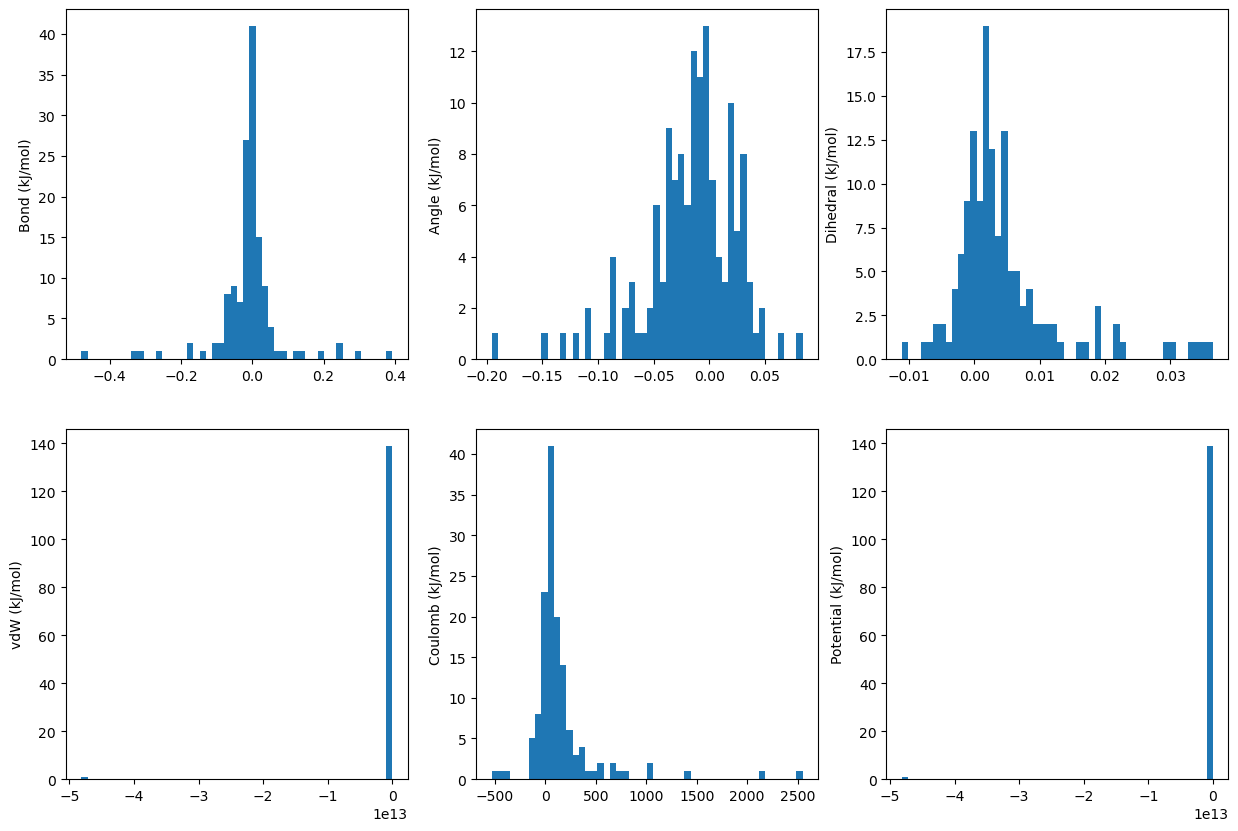

Bond  \
polyamide                  poly(hexane-1,6-diamine-co-dodecanedioic acid)        0.010538929238464334 kJ/mol   
                           poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...     0.04233108344851644 kJ/mol   
                           poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...    -0.05505980836460367 kJ/mol   
                           poly(hexane-1,6-diamine-co-hexanedioic acid)        -0.0057412505557294935 kJ/mol   
                           poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...     -0.0857436946425878 kJ/mol   
...                                                                                                      ...   
polyurethane_nonisocyanate poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...    0.029886496771723614 kJ/mol   
                           poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...    0.018895837070886046 kJ/mol   
                           poly(4-[[4-[2-[4-[(2-oxo-1,3-dioxolan-4-yl)meth...    -0.07315235069108894 kJ/mol   
                           poly(4-[[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...    0.043099572094433825 kJ/mol   
                           poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...     0.09026515075311181 kJ/mol   

                                                                                                       Angle  \
polyamide                  poly(hexane-1,6-diamine-co-dodecanedioic acid)        0.010763245489215478 kJ/mol   
                           poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...     -0.0327637157170102 kJ/mol   
                           poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...  -0.0010294333915226161 kJ/mol   
                           poly(hexane-1,6-diamine-co-hexanedioic acid)         -0.016257754323305562 kJ/mol   
                           poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...     0.03725335019407794 kJ/mol   
...                                                                                                      ...   
polyurethane_nonisocyanate poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...   -0.003388710872968659 kJ/mol   
                           poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...  -0.0015657454205211252 kJ/mol   
                           poly(4-[[4-[2-[4-[(2-oxo-1,3-dioxolan-4-yl)meth...    -0.02428599275299348 kJ/mol   
                           poly(4-[[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...     0.08393239259021357 kJ/mol   
                           poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...    0.044444974075304344 kJ/mol   

                                                                                                   Dihedral  \
polyamide                  poly(hexane-1,6-diamine-co-dodecanedioic acid)       0.004825636468012817 kJ/mol   
                           poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...   0.029849724247469567 kJ/mol   
                           poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...    0.03329294771538116 kJ/mol   
                           poly(hexane-1,6-diamine-co-hexanedioic acid)         0.001955412722963956 kJ/mol   
                           poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...  0.0036158092989353463 kJ/mol   
...                                                                                                     ...   
polyurethane_nonisocyanate poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...   0.002612820484500844 kJ/mol   
                           poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...   0.004774542241648305 kJ/mol   
                           poly(4-[[4-[2-[4-[(2-oxo-1,3-dioxolan-4-yl)meth...  -0.011075868955231272 kJ/mol   
                           poly(4-[[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...      0.010497956238396 kJ/mol   
                           poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...  -0.002275214807013981 kJ/mol   

                                                                                 

In [28]:
import matplotlib.pyplot as plt
from polymerist.graphics.plotutils import presize_subplots


vdW_tol = 0 * kilojoule_per_mole
col_order = ['Bond', 'Angle', 'Dihedral', 'vdW', 'Coulomb', 'Potential']

lattice_size_int = eval(lattice_size.replace('x', '*'))
diff = edfs_fmt['OpenMM'] - edfs_fmt['LAMMPS']
if (vdW_tol > 0*kilojoule_per_mole):
    diff = diff[abs(diff['vdW']) < (vdW_tol * lattice_size_int)] # normalize by number of compounds

fig, ax = presize_subplots(nrows=2, ncols=3)
for col, axis in zip(col_order, ax.flatten()):
    heights, bins, patches = axis.hist([i._value for i in diff[col]], bins=50)
    axis.set_ylabel(f'{col} (kJ/mol)')
    
print(len(diff))
plt.show()
display(diff[col_order])

In [29]:
diff_path = assemble_path(energy_dir, 'Energy_diff_table', postfix=f'{MOL_MASTER_DIR.stem}_{lattice_size}', extension='csv')
diff.to_csv(diff_path)

energy_fig_path = assemble_path(energy_dir, 'Energy_diff_graphs', postfix=f'{MOL_MASTER_DIR.stem}_{lattice_size}', extension='png')
fig.savefig(energy_fig_path)

In [18]:
diff['vdW'].sort_values()

polycarbonate_phosgene   poly(4-[2-(4-hydroxy-3-methylphenyl)propan-2-yl]-2-methylphenol-co-carbonyl dichloride)                                                     -48125588076960.0 kJ/mol
polyurethane_isocyanate  poly(1-isocyanato-4-[(4-isocyanatophenyl)methyl]benzene-co-4-[[4-[(4-hydroxyphenyl)iminomethyl]phenyl]methylideneamino]phenol)             -4897990.007980347 kJ/mol
polyester                poly(butane-1,4-diol-co-terephthalic acid)                                                                                                 -769884.1628923416 kJ/mol
                         poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic acid)                                                                                       -30446.01861667633 kJ/mol
polyurethane_isocyanate  poly(2,4-diisocyanato-1-methylbenzene-co-6-[4-[4-(6-hydroxyhexoxy)phenyl]phenoxy]hexan-1-ol)                                                38.13334277722606 kJ/mol
                                                  

# Getting just the systems which have density data available

In [12]:
def get_polymer_name(row : pd.Series) -> str:
    return f'poly({row["IUPAC_name_monomer_0"]}-co-{row["IUPAC_name_monomer_1"]})'.lower()

p = Path('monomer_data_processed/monomer_data_MASTER.csv')
polyid_df = pd.read_csv(p, index_col=0)

polyid_df['polymer_name'] = polyid_df.apply(get_polymer_name, axis=1) # generate column of polymer names from monomer names
polyid_df.set_index(['rxn_name', 'polymer_name'], inplace=True) # reindex my mechanism and molecule name
polyid_df = polyid_df[polyid_df['Density'].notnull()] # filter by density values

common_index = polyid_df.index.intersection(diff.index)
polyid_df.loc[common_index]['Density']

Series([], Name: Density, dtype: float64)

In [13]:
polyid_df.loc[common_index.sort_values()].to_csv('monomer_data_processed/monomer_data_MASTER_dens_vdW.csv')